# Extract data from ROIs

### Goals of this script
1. load normalized BOLD data (from 01-denoise-sesXX_sub-XXX.ipynb)
2. apply masks
3. save the voxel x TR matrix

### For submitting slurm job:
- approximate time to run for one subject: 1 hr

## Define subject

In [1]:
sub='sub-005'
n_trunc_beginning=14 #Number of volumes to trim/truncate
#n_trunc_end=10

version='v1'
binarization_thresh='75'

rsa_ROIs = ['bilateral_hippo','bilateral_oc-temp']

## Import necessary packages

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
import scipy.io
from scipy import stats
import os
import pickle 
import time
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt
import seaborn as sns
import csv

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The nibabel version is {}.'.format(nib.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

assert python_version()== '3.9.10'
assert nilearn.__version__=='0.8.1'

The python version is 3.9.10.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The nibabel version is 3.2.1.
The seaborn version is 0.11.2.


## Load settings

In [5]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/analysis/mainanalysis')
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer, load_adderzip_epi_data, shift_timing, label2TR

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_TR, adderzip_hrf_lag, run_names, n_runs, TRs_run, run_order_start

shift_size = int(adderzip_hrf_lag / adderzip_TR) # Convert the shift into TRs

deriv_dir=adderzip_bids_dir + 'derivatives/'
anat_dir=deriv_dir + 'deface/'
firstlevel_dir=deriv_dir + 'firstlevel/%s/' % sub
out_dir_level1=firstlevel_dir + 'masked_epi_data_%s/' % version
out_dir=out_dir_level1 + 'threshold-%s/' % binarization_thresh
mask_fold=deriv_dir + 'firstlevel/%s/masks/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('ROIs = %s' % (rsa_ROIs))
print('')
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('volumes trimmed from end of each run depending on n_trunc_end file' )
print('')

# make out_dir if it doesn't exist
if os.path.exists(out_dir_level1)==False:
    print('making new directory:', out_dir_level1)
    os.mkdir(out_dir_level1) 
if os.path.exists(out_dir)==False:
    print('making new directory:', out_dir)
    os.mkdir(out_dir) 

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/masked_epi_data_v1/threshold-75/

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']

14 volumes trimmed from beginning of each run
volumes trimmed from end of each run depending on n_trunc_end file



In [6]:
# Make a function to load the mask data
def load_adderzip_mask(ROI_name, sub):
    """Load the mask for the adderzip data 
    Parameters
    ----------
    ROI_name: string
    sub: string 
    
    Return
    ----------
    the requested mask
    """    
    # load the mask
    maskfile = (mask_fold + sub + "_%s.nii.gz" % (ROI_name))
    mask = nib.load(maskfile)
    print("Loaded %s mask" % (ROI_name))
    return mask

def mask_data(epi_data, mask): 
    """mask the input data with the input mask 
    Parameters
    ----------
    epi_data
    mask
    
    Return
    ----------
    masked data
    """    
    #check that masks and BOLD data match
    assert mask.shape==epi_data.shape[:3] 
    assert mask.header.get_zooms()==epi_data.header.get_zooms()[0:3] #resolution
    assert mask.affine.all()==epi_data.affine.all() #check that affines match
    print('mask shape:', mask.shape, 'dimensions:', mask.header.get_zooms())
    print('mask affine:')
    print(mask.affine)
    
    nifti_masker = NiftiMasker(mask_img=mask)
    epi_masked_data = nifti_masker.fit_transform(epi_data);
    return epi_masked_data

def load_adderzip_masked_data(directory, subject_name, mask_list):
    masked_data_all = [0] * len(mask_list)

    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        # load the mask for the corresponding ROI
        this_mask = mask_list[mask_counter]
        mask = load_adderzip_mask(mask_list[mask_counter], subject_name)
        
        # # plot mask overlayed on subject's T1
        #plot_roi(mask, bg_img=t1_img, title=this_mask)
        
        # mask the data 
        print('extracting masked data for %s' %(this_mask))
        epi_masked_data = mask_data(epi_data, mask)
        epi_masked_data = np.transpose(epi_masked_data)
        
        # Check the dimensionality of the data
        print('voxel by TR matrix - shape: ', epi_masked_data.shape)
        print('')
        
        masked_data_all[mask_counter] = epi_masked_data
        
    return masked_data_all

## Load fMRI data and apply masks

### LOCALIZER

In [8]:
execute=1 #1 to run, 0 to skip
ses='ses-01'
task='localizer'
task_index = run_names.index(task)
n_runs_task = n_runs[task_index]
TRs_run_task=TRs_run[task_index]-n_trunc_beginning-10 #if data are already trimmed, update TRs_run #10 is usual n_trunc_end

print('LIST OF TASKS:', run_names)
print('task index:', task_index)
print('')
print('TR = %s seconds' % (adderzip_TR))
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('volumes trimmed from end of each run depending on n_trun_end file')
print('')
print('Number of %s runs = %s and TRs per run = %s' % (task, n_runs_task, TRs_run[task_index]))
print('TRs per %s run after trimming = %s' % (task,TRs_run_task))
print('')
print('available ROIs: ', rsa_ROIs)

LIST OF TASKS: ['localizer']
task index: 0

TR = 1.5 seconds
14 volumes trimmed from beginning of each run
volumes trimmed from end of each run depending on n_trun_end file

Number of localizer runs = 3 and TRs per run = 194
TRs per localizer run after trimming = 170

available ROIs:  ['bilateral_hippo', 'bilateral_oc-temp']


epi_data shape:  (98, 112, 92, 510) dimensions: (1.5, 1.5, 1.5, 1.5)
task TR number  510
Loading data from /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/ses-01/sub-005_ses-01_task-localizer_run-ALL_space-T1w_desc-preproc_bold_trim14andEndTRs_normalized.nii.gz

epi_data shape:  (98, 112, 92, 510) dimensions: (1.5, 1.5, 1.5, 1.5)
epi_data affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]

Loaded bilateral_hippo mask
extracting masked data for bilateral_hippo
mask shape: (98, 112, 92) dimensions: (1.5, 1.5, 1.5)
mask affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]
voxel by TR matrix - shape:  (1950, 510)

Loaded bilateral_oc-temp mask
extracting masked data for bilateral_oc-temp
mask shape: (98, 112, 92) dimensions: (1.5, 1.5, 1.5)
mask affine:
[[   1.5    0.     0.   -77. ]
 [   0. 

<Figure size 1440x720 with 0 Axes>

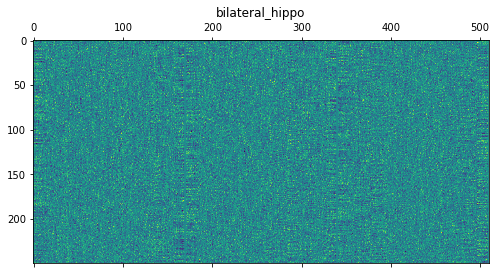

<Figure size 1440x720 with 0 Axes>

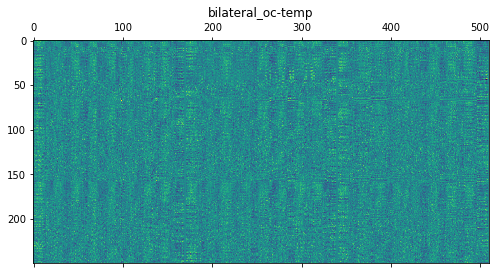

In [9]:
if execute==1:
    
    # load normalized BOLD data
    epi_data=[]
    epi_in = (firstlevel_dir  + ses + "/%s_%s_task-%s_run-ALL_space-T1w_desc-preproc_bold_trim%dandEndTRs_normalized.nii.gz" % (sub, ses, task, n_trunc_beginning))
    epi_data = nib.load(epi_in)
    print('epi_data shape: ', epi_data.shape, 'dimensions:', epi_data.header.get_zooms())
    print('task TR number ', n_runs_task*TRs_run_task)
    
    assert epi_data.shape[3]==n_runs_task*TRs_run_task
    print("Loading data from %s" % (epi_in))
    print('')
    print('epi_data shape: ', epi_data.shape, 'dimensions:', epi_data.header.get_zooms())
    print('epi_data affine:')
    print(epi_data.affine)
    print('')
    
    # Extract voxels for each ROI using NiftiMasker
    masked_data_all = load_adderzip_masked_data(mask_fold, sub, rsa_ROIs)
    
    # Plot data (first 250 voxels only)
    for mask_counter in range(len(rsa_ROIs)):
        this_mask = rsa_ROIs[mask_counter]
        plt.figure(figsize=(20,10))
        plt.matshow(masked_data_all[mask_counter][:250,:]) #[voxel,time]
        plt.title(this_mask)
    
    # Save data
    for mask_counter in range(len(rsa_ROIs)):
        this_mask = rsa_ROIs[mask_counter]
        mat_out = out_dir + '%s_task-%s_run-ALL_space-T1w_trim%dandEndTRs_mask-%s' % (sub, task, n_trunc_beginning, this_mask)
        print('saving to file: ', mat_out)
        print('')
        scipy.io.savemat(mat_out, mdict={'data': masked_data_all[mask_counter]})

    print('Saving complete')

else:
    print('Skipping %s task' % (task))     